In [2]:
import os
import pydicom
from PIL import Image
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch
from src.Models.D_UNet import UNet3D, ResidualUNetSE3D

In [3]:
Dir = '/home/omen/Documents/Rishabh/TrainingDataApp/TrainingData'
MasksPath = os.path.join(Dir, 'Masks')
ImagesPath = os.path.join(Dir, 'Images')
os.listdir(Dir)

['Masks', 'Images']

In [4]:
datadict = {'BackGround' :0, 
            'Bleed-Subdural': 1,  
            'Scalp-Hematoma' :2, 
            'Bleed-Others':3, 
            'Bleed-Intraventricular':4,  
            'Bleed-Epidural': 5 , 
            'Bleed-Contusion': 6, 
            'Bleed-Hematoma' :7, 
            'Bleed-Subarachnoid': 8}

reversed_dict = {v: k for k, v in datadict.items()}

In [5]:
class CustomDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, datadict=datadict):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)
        self.series = os.listdir(mask_dir)
        self.datadict = datadict
        reversed_dict = {v: k for k, v in datadict.items()}
        self.reversed_dict = reversed_dict
    def __len__(self):
        return len(self.series)

    def __getitem__(self, index):
        Maskvolume = []
        ImageVolume = []
        print(self.series[index])
        flag = 0
        for key in range(len(self.reversed_dict.keys())):
            catag = self.reversed_dict[key]
            Maskcatgvolume = []
            Masks = os.path.join(self.mask_dir, os.listdir(self.mask_dir)[index], catag)
            MasksList = os.listdir(Masks)
            MasksList = sorted(MasksList)
            
            for msk in MasksList:
                pngMask = Image.open(os.path.join(Masks, msk))
                pngMask = np.array(pngMask)
                Maskcatgvolume.append(pngMask)
    
                if msk in self.images and flag == 0:
                    pngimage = Image.open(os.path.join(self.image_dir ,msk))
                    pngimage = np.array(pngimage)
                    ImageVolume.append(pngimage)
            flag = 1
                    
            Maskcatgvolume = np.stack(Maskcatgvolume, axis = 0)
            Maskvolume.append(Maskcatgvolume)
            
        Maskvolume = np.stack(Maskvolume, axis = 0)
        ImageVolume = np.stack(ImageVolume, axis = 0)
        NewMaskVolume = []
        NewMaskVolume.append(Maskvolume[0,:,:,:])
        NewMaskVolume.append(Maskvolume[5,:,:,:])
        Maskvolume[6,:,:,:] = Maskvolume[6,:,:,:] + Maskvolume[7,:,:,:]
        Maskvolume[6,:,:,:][Maskvolume[6,:,:,:] > 0] = 1
        NewMaskVolume.append(Maskvolume[6,:,:,:])
        NewMaskVolume.append(Maskvolume[4,:,:,:])
        NewMaskVolume.append(Maskvolume[8,:,:,:])
        NewMaskVolume.append(Maskvolume[1,:,:,:])

        Maskvolume = np.stack(NewMaskVolume, axis = 0)
        
        
        # ImageVolume = np.expand_dims(ImageVolume, axis=0)
        # print(Maskvolume.shape)
        Maskvolume = np.argmax(Maskvolume, axis=0)
        ImageVolume = np.transpose(ImageVolume, (1,2,0))
        Maskvolume = np.transpose(Maskvolume, (1,2,0))

        # ImageVolume = torch.tensor(ImageVolume, dtype=torch.float16)
        # Maskvolume = torch.tensor(Maskvolume, dtype=torch.float16)



        return ImageVolume, Maskvolume

In [6]:
data = CustomDataset(ImagesPath, MasksPath)

In [7]:
ImageVolume, Maskvolume = data[0]

2.25.285141789940989207961066447306753183932


In [8]:
ImageVolume.shape, Maskvolume.shape

((512, 512, 156), (512, 512, 156))

In [9]:
np.unique(Maskvolume)

array([0, 2, 3])

In [10]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch.nn.functional as F

IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128
train_transform = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ],
)

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResidualUNetSE3D(in_channels=1, out_channels=6).to(device)
checkpoint = torch.load('/home/omen/Documents/Rishabh/New_Bleed_model/model_checkpoint_residualSE3D_BHSD.pth')  # or 'model_checkpoint.pth.tar' 
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [12]:
def dice_score_binary(preds: torch.Tensor, targets: torch.Tensor, smooth=1e-6):
    """
    Computes Dice Score for binary segmentation.

    Args:
        preds (torch.Tensor): Predictions (N, 1, H, W, [D]) — logits or probs.
        targets (torch.Tensor): Ground truth binary masks (N, 1, H, W, [D]).
        smooth (float): Smoothing term to avoid division by zero.

    Returns:
        float: Dice score.
    """
    preds = torch.sigmoid(preds) if preds.max() > 1 else preds  # Convert logits to probs if needed
    preds = (preds > 0.5).float()  # Binarize predictions

    intersection = (preds * targets).sum()
    union = preds.sum() + targets.sum()

    dice = (2. * intersection + smooth) / (union + smooth)
    return dice.item()

In [13]:
import numpy as np

def compute_confusion_matrix(y_true, y_pred):
    """
    y_true: ndarray of shape (C, D, H, W), binary (0 or 1)
    y_pred: ndarray of shape (C, D, H, W), binary (0 or 1)
    Returns:
        conf_matrix: (C, C) where entry (i, j) = true class i predicted as j
    """
    C = y_true.shape[0]
    conf_matrix = np.zeros((C, C), dtype=np.int64)

    for i in range(C):  # true class
        for j in range(C):  # predicted class
            # Count where class i is present in true and class j in pred
            intersection = (y_true[i] == 1) & (y_pred[j] == 1)
            conf_matrix[i, j] = np.sum(intersection)

    return conf_matrix


In [70]:
perclassDiceScore = {
    "Background":[],
    "Epidural Hemorrhage (EDH)": [],
    "Intraparenchymal Hemorrhage (IPH)": [],
    "Intraventricular Hemorrhage (IVH)": [],
    "Subarachnoid Hemorrhage (SAH)": [],
    "Subdural Hemorrhage (SDH)": [],
}
classesmaping = {
    0 : "Background",
    1 : "Epidural Hemorrhage (EDH)",
    2 : "Intraparenchymal Hemorrhage (IPH)",
    3 : "Intraventricular Hemorrhage (IVH)",
    4 : "Subarachnoid Hemorrhage (SAH)",
    5 : "Subdural Hemorrhage (SDH)",
}
conf_matrix = np.zeros((6, 6), dtype=np.int64)
for i in range(len(data)):
    img_data, msk_data = data[i]
    slicesCount = 32
    mul = 0
    while slicesCount*mul <= img_data.shape[2]:
        sub_img_data = img_data[:,:,slicesCount*mul:slicesCount*(mul+1)]
        sub_msk_data = msk_data[:,:,slicesCount*mul:slicesCount*(mul+1)]

        if sub_img_data.shape[2] >= 16:
            transformed = train_transform(image=sub_img_data, mask=sub_msk_data)
            img_tensor = transformed['image'] 
            orig_mask = transformed["mask"]
            orig_mask = F.one_hot(orig_mask.long(), num_classes=6)
            orig_mask = torch.permute(orig_mask, (3,2,0,1))
            print(orig_mask.shape, '  ', torch.unique(orig_mask))
            
            img_tensor = img_tensor.unsqueeze(0)
            img_tensor = img_tensor.unsqueeze(0)

            img_tensor = img_tensor.to(device)
            pred = model(img_tensor)
            pred = pred.squeeze(0)
            pred = torch.argmax(pred, axis=0)
            pred = F.one_hot(pred.long(), num_classes=6)
            pred = torch.permute(pred, (3, 0, 1, 2))
            pred = pred.cpu()

            print(pred.shape,'  ',torch.unique(pred))

            for i in range(6):
                DiceScore = dice_score_binary(pred[i,:,:,:], orig_mask[i,:,:,:])
                perclassDiceScore[classesmaping[i]].append(DiceScore)
                CF = compute_confusion_matrix(orig_mask.cpu().detach().numpy(), pred.cpu().detach().numpy())
                conf_matrix = conf_matrix + CF
                print(DiceScore)

            # DiceScore = dice_score_binary(pred, orig_mask)
            # print(DiceScore)
            # pred = pred.cpu().detach().numpy()
            
            # print(pred.shape,'  ',np.unique(pred))

            
        # print(img_data[:,:,slicesCount*mul:slicesCount*(mul+1)].shape)
        mul = mul + 1
    print(msk_data.shape)

2.25.285141789940989207961066447306753183932
torch.Size([6, 32, 128, 128])    tensor([0, 1])
torch.Size([6, 32, 128, 128])    tensor([0, 1])
0.998977541923523
8.130081496915409e-09
1.4064697184679176e-09
1.3513513863472326e-08
1.9999995970465534e-07
6.329114121683688e-09
torch.Size([6, 32, 128, 128])    tensor([0, 1])
torch.Size([6, 32, 128, 128])    tensor([0, 1])
0.9997376799583435
1.0416666640367112e-08
1.724137987935137e-08
1.4084506894107562e-08
9.090908292819222e-08
2.5641025303002607e-08
torch.Size([6, 32, 128, 128])    tensor([0, 1])
torch.Size([6, 32, 128, 128])    tensor([0, 1])
0.9991495609283447
2.512562824463771e-09
8.130081496915409e-09
4.166666300875477e-08
4.999997713639459e-07
2.9069766593892155e-09
torch.Size([6, 32, 128, 128])    tensor([0, 1])
torch.Size([6, 32, 128, 128])    tensor([0, 1])
0.9994990825653076
3.1249999921101335e-08
3.0581039922594755e-09
1.8518518274390772e-08
2.499999425253918e-07
9.259259137195386e-09
torch.Size([6, 28, 128, 128])    tensor([0, 1]

In [71]:
conf_matrix

array([[2597971392,     577734,     297462,      39894,      53844,
           1449750],
       [    434436,          0,          0,          0,          0,
                 0],
       [   2073252,        150,        138,        312,         12,
               540],
       [    431910,        348,        618,          0,         30,
               702],
       [    287520,        120,          6,          0,         30,
               414],
       [    845364,         78,          6,          0,          6,
               108]])

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt
def plot_confusion_matrix(conf_matrix, class_names=None, normalize=False):
    import numpy as np
    import seaborn as sns
    import matplotlib.pyplot as plt

    matrix = np.array(conf_matrix)

    # if normalize:
    #     matrix = matrix.astype(np.float64)
    #     row_sums = matrix.sum(axis=1, keepdims=True)
    #     row_sums[row_sums == 0] = 1
    #     matrix = matrix / row_sums
    #     fmt = ".2f"
    # else:
    #     matrix = matrix.astype(np.float64)
    #     fmt = "d"

    fmt = ".2f"

    # Fix: force annotations to be formatted correctly even if matrix becomes float
    annot_data = np.empty_like(matrix).astype(str)
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            annot_data[i, j] = f"{matrix[i, j]:{fmt}}"

    plt.figure(figsize=(16, 10))
    sns.heatmap(matrix, annot=annot_data, fmt="", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Class")
    plt.ylabel("True Class")
    plt.title("Confusion Matrix" + (" (Normalized)" if normalize else ""))
    plt.tight_layout()
    plt.savefig("Radpretation_dataset_confusion_matrix.png", dpi=300, bbox_inches="tight")
    plt.show()


int64
[[ 99   0   0   0   0   0]
 [100   0   0   0   0   0]
 [ 99   0   0   0   0   0]
 [ 99   0   0   0   0   0]
 [ 99   0   0   0   0   0]
 [ 99   0   0   0   0   0]]


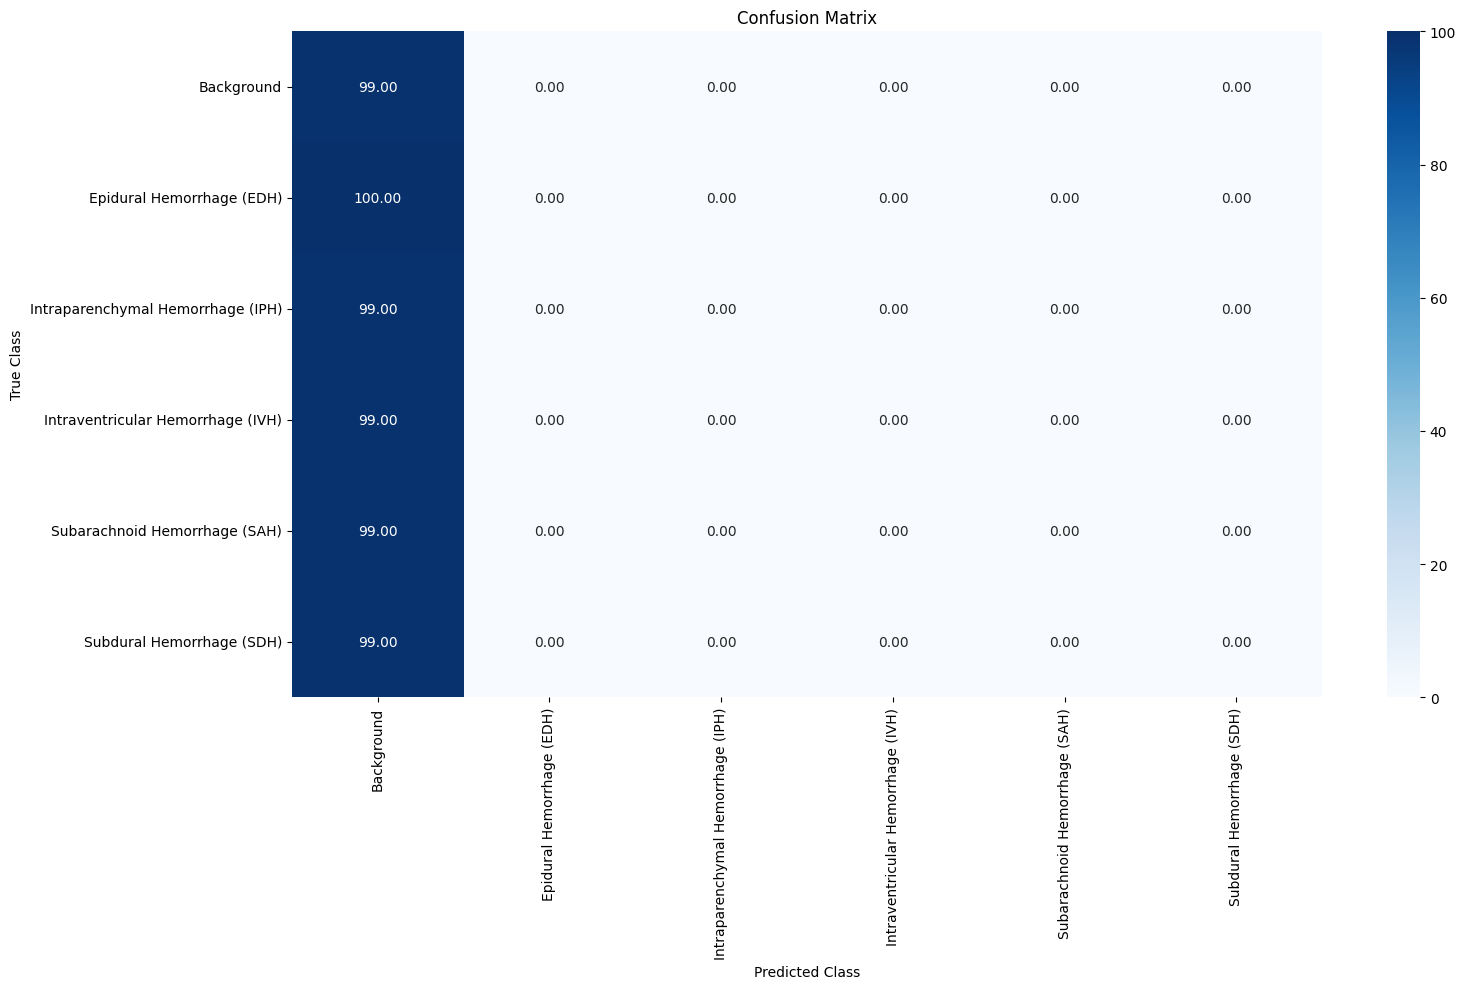

In [74]:
class_names = ["Background",
    "Epidural Hemorrhage (EDH)",
    "Intraparenchymal Hemorrhage (IPH)",
    "Intraventricular Hemorrhage (IVH)",
    "Subarachnoid Hemorrhage (SAH)",
    "Subdural Hemorrhage (SDH)",]

conf_matrix = np.round(new_conf_matrix).astype(int)  # Round first to avoid tiny floats
print(new_conf_matrix.dtype)  # Should print: int
print(new_conf_matrix)
plot_confusion_matrix(new_conf_matrix, class_names=class_names, normalize=False)

# plot_confusion_matrix(conf_matrix, class_names=class_names, normalize=False)


In [72]:
# conf_matrix = [[591531942  ,    8634  ,   89562 ,    31062 ,    39822    , 56346],
#  [    37578  ,   69846 ,     2286  ,      24   ,    144    ,  1404],
#  [   116370   ,    696   , 754044,      3384    ,  2334     , 3546],
#  [    69672    ,     6   ,  18282   , 175122    ,  1014     ,  240],
#  [   169356 ,       24  ,    1962  ,     204   , 117480    ,  3036],
#  [   191628  ,     804    ,   564    ,    24    ,   696  ,  257022],]]
# print(conf_matrix.dtype)
# print(conf_matrix)
rows = []
new_conf_matrix = []
for i in range(len(conf_matrix)):
    print(conf_matrix[i],"  ", sum(conf_matrix[i]) )
    print(conf_matrix[i]/sum(conf_matrix[i]))
    conf_matrix[i] = (conf_matrix[i]/sum(conf_matrix[i]))*100
    
# for row in conf_matrix:
#     rows.append(sum(row))

# new_conf_matrix = (conf_matrix/rows)*100
# print(((conf_matrix/rows)*100))

[2597971392     577734     297462      39894      53844    1449750]    2600390076
[9.99069876e-01 2.22172052e-04 1.14391299e-04 1.53415445e-05
 2.07061242e-05 5.57512511e-04]
[434436      0      0      0      0      0]    434436
[1. 0. 0. 0. 0. 0.]
[2073252     150     138     312      12     540]    2074404
[9.99444660e-01 7.23099261e-05 6.65251320e-05 1.50404646e-04
 5.78479409e-06 2.60315734e-04]
[431910    348    618      0     30    702]    433608
[9.96084021e-01 8.02568218e-04 1.42525046e-03 0.00000000e+00
 6.91869154e-05 1.61897382e-03]
[287520    120      6      0     30    414]    288090
[9.98021452e-01 4.16536499e-04 2.08268250e-05 0.00000000e+00
 1.04134125e-04 1.43705092e-03]
[845364     78      6      0      6    108]    845562
[9.99765836e-01 9.22463403e-05 7.09587233e-06 0.00000000e+00
 7.09587233e-06 1.27725702e-04]


In [76]:
conf_matrix

array([[ 99,   0,   0,   0,   0,   0],
       [100,   0,   0,   0,   0,   0],
       [ 99,   0,   0,   0,   0,   0],
       [ 99,   0,   0,   0,   0,   0],
       [ 99,   0,   0,   0,   0,   0],
       [ 99,   0,   0,   0,   0,   0]])

In [73]:
new_conf_matrix = conf_matrix
for i in range(len(new_conf_matrix)):
    print(sum(new_conf_matrix[i]))

99
100
99
99
99
99


In [62]:
conf_matrix = [[591531942  ,    8634  ,   89562 ,    31062 ,    39822    , 56346],
 [    37578  ,   69846 ,     2286  ,      24   ,    144    ,  1404],
 [   116370   ,    696   , 754044,      3384    ,  2334     , 3546],
 [    69672    ,     6   ,  18282   , 175122    ,  1014     ,  240],
 [   169356 ,       24  ,    1962  ,     204   , 117480    ,  3036],
 [   191628  ,     804    ,   564    ,    24    ,   696  ,  257022],]
conf_matrix = np.array(conf_matrix)

print(conf_matrix[0][0])

591531942


In [18]:
for key in perclassDiceScore.keys():
    print(key, ':- ', sum(perclassDiceScore[key])/len(perclassDiceScore[key]))
    

Background :-  0.9993576109409332
Epidural Hemorrhage (EDH) :-  9.27337406864126e-09
Intraparenchymal Hemorrhage (IPH) :-  9.323924798909644e-09
Intraventricular Hemorrhage (IVH) :-  1.3799010378789944e-08
Subarachnoid Hemorrhage (SAH) :-  1.9999995970465534e-07
Subdural Hemorrhage (SDH) :-  6.329114121683688e-09


In [19]:
import nibabel as nib
Dir = "/home/omen/Downloads/label_192"
masks_path = os.path.join(Dir, 'ground truths')
images_path = os.path.join(Dir, 'images')
masks = os.listdir(masks_path)
images = os.listdir(images_path)

In [20]:
perclassDiceScore = {
    "Background":[],
    "Epidural Hemorrhage (EDH)": [],
    "Intraparenchymal Hemorrhage (IPH)": [],
    "Intraventricular Hemorrhage (IVH)": [],
    "Subarachnoid Hemorrhage (SAH)": [],
    "Subdural Hemorrhage (SDH)": [],
}
classesmaping = {
    0 : "Background",
    1 : "Epidural Hemorrhage (EDH)",
    2 : "Intraparenchymal Hemorrhage (IPH)",
    3 : "Intraventricular Hemorrhage (IVH)",
    4 : "Subarachnoid Hemorrhage (SAH)",
    5 : "Subdural Hemorrhage (SDH)",
}

conf_matrix = np.zeros((6, 6), dtype=np.int64)
for i in range(len(images)):
    img = nib.load(os.path.join(images_path, images[i]))
    msk = nib.load(os.path.join(masks_path, images[i]))
    img_data = img.get_fdata()
    msk_data = msk.get_fdata()
    
    # Print the shape of the data
    print(img_data.shape,'  ',msk_data.shape)

    # img_data, msk_data = data[i]
    slicesCount = 32
    mul = 0
    while slicesCount*mul <= img_data.shape[2]:
        sub_img_data = img_data[:,:,slicesCount*mul:slicesCount*(mul+1)]
        sub_msk_data = msk_data[:,:,slicesCount*mul:slicesCount*(mul+1)]

        if sub_img_data.shape[2] >= 16:
            transformed = train_transform(image=sub_img_data, mask=sub_msk_data)
            img_tensor = transformed['image'] 
            orig_mask = transformed["mask"]
            orig_mask = F.one_hot(orig_mask.long(), num_classes=6)
            orig_mask = torch.permute(orig_mask, (3,2,0,1))
            print(orig_mask.shape, '  ', torch.unique(orig_mask))
            
            img_tensor = img_tensor.unsqueeze(0)
            img_tensor = img_tensor.unsqueeze(0)

            img_tensor = img_tensor.to(device)
            pred = model(img_tensor)
            pred = pred.squeeze(0)
            pred = torch.argmax(pred, axis=0)
            pred = F.one_hot(pred.long(), num_classes=6)
            pred = torch.permute(pred, (3, 0, 1, 2))
            pred = pred.cpu()

            print(pred.shape,'  ',torch.unique(pred))

            for i in range(6):
                # DiceScore = dice_score_binary(pred[i,:,:,:], orig_mask[i,:,:,:])
                # perclassDiceScore[classesmaping[i]].append(DiceScore)
                # print(DiceScore)

                DiceScore = dice_score_binary(pred[i,:,:,:], orig_mask[i,:,:,:])
                perclassDiceScore[classesmaping[i]].append(DiceScore)
                CF = compute_confusion_matrix(orig_mask.cpu().detach().numpy(), pred.cpu().detach().numpy())
                conf_matrix = conf_matrix + CF
                print(DiceScore)

            # DiceScore = dice_score_binary(pred, orig_mask)
            # print(DiceScore)
        
            # pred = pred.cpu().detach().numpy()
            
            # print(pred.shape,'  ',np.unique(pred))

            
        # print(img_data[:,:,slicesCount*mul:slicesCount*(mul+1)].shape)
        mul = mul + 1
    print(msk_data.shape)

(512, 512, 32)    (512, 512, 32)
torch.Size([6, 32, 128, 128])    tensor([0, 1])
torch.Size([6, 32, 128, 128])    tensor([0, 1])
0.9997801780700684
1.0
0.9043841361999512
1.0
1.0
9.99999087980541e-07
(512, 512, 32)
(512, 512, 32)    (512, 512, 32)
torch.Size([6, 32, 128, 128])    tensor([0, 1])
torch.Size([6, 32, 128, 128])    tensor([0, 1])
0.9998452663421631
1.0
0.9036861062049866
1.0
1.0
1.0
(512, 512, 32)
(512, 512, 32)    (512, 512, 32)
torch.Size([6, 32, 128, 128])    tensor([0, 1])
torch.Size([6, 32, 128, 128])    tensor([0, 1])
0.9997977614402771
1.0
1.0
0.5563910007476807
0.35983264446258545
1.0
(512, 512, 32)
(512, 512, 32)    (512, 512, 32)
torch.Size([6, 32, 128, 128])    tensor([0, 1])
torch.Size([6, 32, 128, 128])    tensor([0, 1])
0.9995487928390503
0.5287958383560181
1.0
1.0
1.0
0.8635513782501221
(512, 512, 32)
(512, 512, 28)    (512, 512, 28)
torch.Size([6, 28, 128, 128])    tensor([0, 1])
torch.Size([6, 28, 128, 128])    tensor([0, 1])
0.9958063960075378
1.0
0.817813

In [89]:
#256, 256
for key in perclassDiceScore.keys():
    print(key, ':- ', sum(perclassDiceScore[key])/len(perclassDiceScore[key]))

Background :-  0.9993098491860419
Epidural Hemorrhage (EDH) :-  0.8179556443457805
Intraparenchymal Hemorrhage (IPH) :-  0.6866261524736667
Intraventricular Hemorrhage (IVH) :-  0.6447530754861122
Subarachnoid Hemorrhage (SAH) :-  0.4963120479824292
Subdural Hemorrhage (SDH) :-  0.5303758347480635


In [76]:
#128, 128
for key in perclassDiceScore.keys():
    print(key, ':- ', sum(perclassDiceScore[key])/len(perclassDiceScore[key]))

Epidural Hemorrhage (EDH) :-  0.7934175918746128
Intraparenchymal Hemorrhage (IPH) :-  0.6147362585897279
Intraventricular Hemorrhage (IVH) :-  0.5701192526208283
Subarachnoid Hemorrhage (SAH) :-  0.3851913354301424
Subdural Hemorrhage (SDH) :-  0.505268934351448


In [ ]:
img_data, msk_data = data[0]

In [57]:
float(7.999999773744548e-09)

7.999999773744548e-09

In [ ]:
slicesCount = 24
i = 0
while slicesCount*i <= img_data.shape[2]:
    print(img_data[:,:,slicesCount*i:slicesCount*(i+1)].shape)
    i = i + 1

In [ ]:
24*6+12

In [ ]:
img_data, msk_data = data[0]
slicesCount = 16
img_data = img_data[:,:,:slicesCount]
msk_data = msk_data[:,:,:slicesCount]
transformed = train_transform(image=img_data, mask=msk_data)
img_tensor = transformed['image']  # This will be a torch.Tensor
orig_mask = transformed["mask"]
img_tensor = img_tensor.unsqueeze(0)
img_tensor = img_tensor.unsqueeze(0)

img_tensor = img_tensor.to(device)
print(img_tensor.shape)
pred = model(img_tensor)
pred = pred.squeeze(0)
pred = pred.cpu().detach().numpy()
pred = np.argmax(pred, axis=0)

In [ ]:
from PIL import Image
def save_prediction(image, mask):
    gray_image = image
    binary_mask = mask
    
    gray_norm = gray_image / 255.0

    # Create an RGB image with grayscale as background
    overlay = np.stack([gray_norm, gray_norm, gray_norm], axis=-1)
    
    # Define lighter colors for each class (0-8)
    colors = {
        1: [1.0, 0.6, 0.6],   # Light Red
        2: [0.6, 1.0, 0.6],   # Light Green
        3: [0.6, 0.6, 1.0],   # Light Blue
        4: [1.0, 1.0, 0.6],   # Light Yellow
        5: [1.0, 0.6, 1.0],   # Light Magenta
        6: [0.6, 1.0, 1.0],   # Light Cyan
        7: [0.8, 0.7, 1.0],   # Light Purple
        8: [1.0, 0.8, 0.6]    # Light Orange
    }
    
    # Create an RGB mask initialized with zeros
    mask_rgb = np.zeros_like(overlay)

    
    # Assign colors based on binary_mask values
    for value, color in colors.items():
        mask_rgb[binary_mask == value] = color

    # Define transparency level
    alpha = 0.7  # Transparency level (0-1)
    
    # Blend grayscale image with the colored mask
    blended = overlay * (1 - alpha) + mask_rgb * alpha
    blended = (blended*255).astype(np.uint8)
    return blended

In [ ]:
img_tensor = img_tensor.squeeze(0)
img_tensor = img_tensor.squeeze(0)
img_tensor = img_tensor.cpu().detach().numpy()

In [ ]:
import matplotlib.pyplot as plt
sli = 18
print(img_tensor.shape)
print(np.unique(pred[sli,:,:]))
blend = save_prediction(img_tensor[sli,:,:]*255, pred[sli,:,:])
blend = Image.fromarray(blend)
orignalblend = save_prediction(img_tensor[sli,:,:]*255, orig_mask[:,:, sli])
orignalblend = Image.fromarray(orignalblend)

# Display side-by-side using matplotlib
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(blend)
axs[0].set_title('Predicted Mask')
axs[0].axis('off')

axs[1].imshow(orignalblend)
axs[1].set_title('Original Mask')
axs[1].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
np.unique(pred)

In [3]:
import gradio as gr
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import io
import nibabel as nib


def slice_to_image(slice_2d):
    """
    Converts a 2D numpy array or 3D RGB image (H, W) or (H, W, 3) to a PIL Image
    using matplotlib to save to an in-memory PNG buffer.

    If slice_2d is grayscale (2D), it uses cmap='gray'.
    If RGB (3D with 3 channels), it shows as-is.
    """
    fig, ax = plt.subplots()
    
    if slice_2d.ndim == 2:
        ax.imshow(slice_2d, cmap='gray')
    elif slice_2d.ndim == 3 and slice_2d.shape[2] == 3:
        ax.imshow(slice_2d)
    else:
        raise ValueError("Input slice must be 2D grayscale or 3D RGB image.")
    
    ax.axis('off')
    buf = io.BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight', pad_inches=0)
    buf.seek(0)
    plt.close()
    return Image.open(buf)


# Show slices from stored volumes
def show_all_slices(slice_idx, volumes):
    image1, image2, image3 = volumes
    img1 = slice_to_image(image1[:, :, slice_idx])
    img2 = slice_to_image(image2[:, :, :, slice_idx])
    img3 = slice_to_image(image3[:, :, :, slice_idx])
    return img1, img2, img3

# Handle file upload
def handle_upload(file):
    try:
        # img = nib.load(file.name)
        # data = img.get_fdata()

        # values = [0, 1, 2, 3]
        # probabilities = [0.65, 0.20, 0.13, 0.02]  # 10%, 30%, 60%
        
        # original_mask = np.random.choice(values, size=data.shape, p=probabilities)
        # Pred_mask = np.random.choice(values, size=data.shape, p=probabilities)

        # original_mask = save_prediction_3d(data, original_mask)
        # Pred_mask = save_prediction_3d(data, Pred_mask)

        # print(original_mask.shape, ' ', Pred_mask.shape)
        
        
        
        # z_dim = data.shape[2]

        
        volumes = (data, original_mask, Pred_mask)
        return "File uploaded successfully.", volumes, gr.update(maximum=z_dim - 1, value=0)
    except Exception as e:
        fallback = (np.random.rand(128, 128, 50),) * 3
        return f"Error: {str(e)}", fallback, gr.update(maximum=49, value=0)

# Gradio interface
with gr.Blocks() as demo:
    gr.Markdown("## 🗂 Upload NIfTI and View Slices")

    volume_state = gr.State((np.random.rand(128, 128, 50),) * 3)

    with gr.Row():
        file_input = gr.File(label="Upload .nii or .nii.gz")
        upload_status = gr.Textbox(label="Upload Status", interactive=False)

    slice_slider = gr.Slider(minimum=0, maximum=49, step=1, value=0, label="Slice Index")

    with gr.Row():
        img1 = gr.Image(label="Image 1")
        img2 = gr.Image(label="Image 2")
        img3 = gr.Image(label="Image 3")

    file_input.change(fn=handle_upload,
                      inputs=file_input,
                      outputs=[upload_status, volume_state, slice_slider])
    

    slice_slider.change(fn=show_all_slices,
                        inputs=[slice_slider, volume_state],
                        outputs=[img1, img2, img3])
demo.launch()

* Running on local URL:  http://127.0.0.1:7861
* To create a public link, set `share=True` in `launch()`.
